# Basic example to use BO optimizer w/ GP

This code will run an offline example as-is without any input arguments. Simply run the file in python.

In order to use it on a specific machine:
1. Change the *importlib.import_module('machine_interfaces.machine_interface_example')* to your machine interface name.
2. Select the name of your .npy file that contains your desired scan params, or change directly the parameters.
3. Choose if you want results saved by setting saveResultsQ = True/False.
   *Note:* If saveResultsQ is set to True, the scan data will be saved to the local directory called 'saved_results' and will have filename formatted as 'scan_YYYY-MM-DD-hhmmss.npy'


In [1]:
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")

from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP

saveResultsQ = False

### Import machine interface

In [2]:
mi_module = importlib.import_module('machine_interfaces.machine_interface_example')

### Set parameters 
*Here we could either load from a file or choose the parameters directly*

In [3]:
#load the dict that contains the parameters for the scan (control pv list, starting settings, and gp hyperparams)
scan_params_filename = 'my_scan_params.npy'
scan_params = np.load('params/'+scan_params_filename, allow_pickle=True).item()

In [4]:
acquisition_delay = scan_params['acquisition_delay'] # how long to wait between acquisitions
dev_ids = scan_params['dev_ids']
start_point = scan_params['start_point'] #if start_point is set to None, the optimizer will start from the current device settings.

# GP parameters
gp_precisionmat = 0.25*scan_params['gp_precisionmat']
gp_amp = scan_params['gp_amp'] 
gp_noise_variance =scan_params['gp_noise'] 

*Next we are going to create the machine interface. For this basic example the objective is an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1.*

In [5]:
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 

In [6]:
#check objective noise std
y = [mi.getState()[1][0] for x in range(100)]
np.std(y)

0.0008661177929800382

### Create the GP model

In [7]:
ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude': gp_amp, 'noise_var': gp_noise_variance} 
gp = OGP(ndim, hyperparams)

In [8]:
np.diag(hyperparams['precisionMatrix']**-0.5)

array([1.41421356, 1.41421356, 1.41421356, 1.41421356])

### Create the BO
*create the bayesian optimizer that will use the gp as the model to optimize the machine.*

In [9]:
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = scan_params['ucb_params'] #set the acquisition function parameters
print('ucb_params',opt.ucb_params)

target_func =  <machine_interfaces.machine_interface_example.machine_interface object at 0x000001A40277D048>
********* BO - self.mi = self.target_func worked!
Supposed to be grabbing initial machine state...
x_init [[2. 2. 2. 2.]]
y_init [[0.00064167]]
ucb_params [2.0, None]


### Run the optimization
*run the gp search for some number of steps*

In [10]:
Obj_state_s=[]

iteration = 9
current position: [[-0.68127667 -1.0853277   0.49035153 -0.59269513]] current objective value: [[0.65364291]]


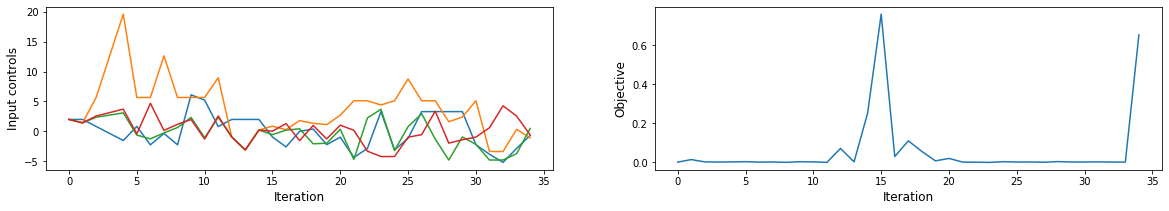

In [14]:
Niter = 10
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', mi.getState()[1])
   
    Obj_state_s.append(mi.getState()[1][0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Input controls',fontsize=12)
    ax.set_xlabel('Iteration',fontsize=12)
    ax.plot(opt.X_obs)
    ax2.set_ylabel('Objective',fontsize=12)
    ax2.set_xlabel('Iteration',fontsize=12)
    ax2.plot(Obj_state_s)
    plt.show(); 
    
    opt.OptIter()
    time.sleep(acquisition_delay)

In [13]:
#save results if desired
if saveResultsQ == True:
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results')
    except: pass
    results = {}
    results['scan_params'] = scan_params
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/scan_'+timestr, results)